# Libs

In [171]:
import PIL
import PIL.Image as Image
import cv2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import torch
from torchvision import transforms

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [453]:
im_size = 128

# Get_image

In [454]:
def get_img(path, size):
    img = PIL.Image.open(path)
    img = img.resize((size, size))
    img_array = np.array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array/255.0
    return tf.convert_to_tensor(img_array)

In [455]:
content_img = get_img('input_image/me.jpg', im_size)
style_img = get_img('input_image/picasso.jpg', im_size)
target_img = tf.image.convert_image_dtype(style_img, tf.float32)
target_img = tf.Variable([target_img])

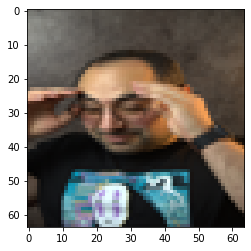

In [421]:
# content
plt.imshow(content_img[0])

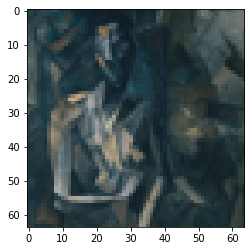

In [422]:
# style
plt.imshow(style_img[0])

# Functions

In [456]:
# function for a gram matrix operation
def gram_transfer(m):
    result = tf.linalg.einsum('bijc,bijd->bcd', m, m)
    gram = tf.expand_dims(result, axis=0)
    shape = tf.shape(m)
    i_j = tf.cast(shape[1]*shape[2], tf.float32)
    return gram/i_j

In [424]:
# load Vgg16
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(im_size,im_size,3),
    include_top=False
)

In [126]:
content_img = get_img('input_image/dancing.jpg')
content_img = tf.reshape(content_img, [1,im_size,im_size,3])
style_img = get_img('input_image/saryan.jpg')
style_img = tf.reshape(style_img, [1,im_size,im_size,3])
target_img = 0.5*(content_img+style_img)

In [127]:
base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(im_size,im_size,3),
    include_top=False
)

vgg_layers = []
vgg_layers.append(base_model.layers[0])
for layer in base_model.layers:
    if "conv" in layer.name:
        layer.trainable = False
        vgg_layers.append(layer)

for layers in vgg_layers:
    print(f"{layers.name} ---> {layers.output_shape}")

input_2 ---> [(None, 128, 128, 3)]
block1_conv1 ---> (None, 128, 128, 64)
block1_conv2 ---> (None, 128, 128, 64)
block2_conv1 ---> (None, 64, 64, 128)
block2_conv2 ---> (None, 64, 64, 128)
block3_conv1 ---> (None, 32, 32, 256)
block3_conv2 ---> (None, 32, 32, 256)
block3_conv3 ---> (None, 32, 32, 256)
block4_conv1 ---> (None, 16, 16, 512)
block4_conv2 ---> (None, 16, 16, 512)
block4_conv3 ---> (None, 16, 16, 512)
block5_conv1 ---> (None, 8, 8, 512)
block5_conv2 ---> (None, 8, 8, 512)
block5_conv3 ---> (None, 8, 8, 512)


In [128]:
def VGG_Net(layers):

    model = keras.models.Sequential()
    for layer in layers[:6]:
        layer.trainable = True
        model.add(layer)

    return model

In [463]:
vgg_c = VGG_Net(vgg_layers)
vgg_s = VGG_Net(vgg_layers)
vgg_t = VGG_Net(vgg_layers)

In [464]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
b_loss = keras.losses.BinaryCrossentropy()

In [13]:
vgg_t.compile(loss=b_loss, optimizer=optimizer)

In [14]:
epochs = 100

target0 = vgg_t(target_img)

loss_collection= []
for epoch in range(epochs):

    target = vgg_t(target_img)

    loss, loss_c, loss_s = 0, 0, 0

    cont_l = content_img
    style_l = style_img
    target_l = target_img

    with tf.GradientTape() as g_tape:
        for n,layer in enumerate(vgg_t.layers):

            cont_l = vgg_c.layers[n](cont_l)
            target_l = vgg_t.layers[n](target_l)

            loss_c += tf.norm(cont_l-target_l)
            
            style_l = vgg_s.layers[n](style_l)
            _, c, h, w = style_l.shape
            style_l_t = tf.reshape(style_l, (c, h * w))
            target_l_t = tf.reshape(target_l, (c, h * w))
            
            loss_s += tf.norm(style_l_t-target_l_t)

    loss = loss_s
    grad = g_tape.gradient(loss, vgg_t.trainable_variables)
    optimizer.apply_gradients(zip(grad, vgg_t.trainable_variables))
    loss_collection.append(loss)

target1 = vgg_t(target_img)
print(tf.norm(target1-target0))

tf.Tensor(2777.3296, shape=(), dtype=float32)


Text(0, 0.5, 'Loss')

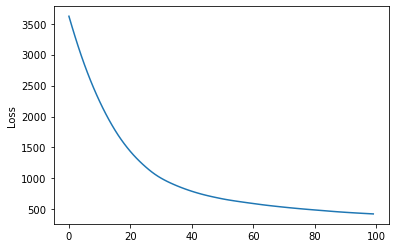

In [15]:
plt.plot(loss_collection)
plt.ylabel("Loss")

# model

In [457]:
def get_loss(content, style, target):
    
    x = 0.3

    content_l = vgg(content)[0]
    style_l = vgg(style)[0]
    target_l = vgg(tf.reshape(target, [1,im_size,im_size,3]))[0]
    
    loss_ct, loss_st = 0, 0
    num_of_layers = len(content_l)
    for c,s,t in zip(content_l, style_l, target_l):
        loss_ct += tf.reduce_mean((c - t)**2)
        s = gram_transfer(s)
        t = gram_transfer(t)
        loss_st += tf.reduce_mean((s - t)**2)
    loss = x*loss_ct + (1-x)*loss_st
    
    return loss/num_of_layers

In [458]:
# make a model from convolutional layers of the base_model
K.clear_session()

base_model = keras.applications.vgg16.VGG16(
    weights='imagenet',
    input_shape=(im_size,im_size,3),
    include_top=False
)

def make_Vgg_Net():
    
    vgg_layers = []
    for layer in base_model.layers:
        if layer.name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
            layer.trainable = False
            vgg_layers.append(layer.output)
    model = keras.models.Model([base_model.input], [vgg_layers])
    return model

vgg = make_Vgg_Net()

In [459]:
starting_time = time.time()
epochs = 16000
opt = tf.optimizers.Adam(learning_rate=5e-5)
loss_collection= []
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        loss = get_loss(content_img, style_img, target_img)
    gradient = tape.gradient(loss, target_img)
    opt.apply_gradients([(gradient, target_img)])
    target_img.assign(tf.clip_by_value(target_img, clip_value_min=0.0, clip_value_max=1.0))
    if epoch % 500 ==0:
        tf.print(f"Loss = {round(float(loss), 3)} {epoch}")
    loss_collection.append(loss)
print("time spent: ", time.time()-starting_time)

Loss = 5.376 0
Loss = 4.554 500
Loss = 4.073 1000
Loss = 3.758 1500
Loss = 3.523 2000
Loss = 3.327 2500
Loss = 3.16 3000
Loss = 3.015 3500
Loss = 2.886 4000
Loss = 2.773 4500
Loss = 2.673 5000
Loss = 2.59 5500
Loss = 2.519 6000
Loss = 2.463 6500
Loss = 2.416 7000
Loss = 2.38 7500
Loss = 2.35 8000
Loss = 2.326 8500
Loss = 2.307 9000
Loss = 2.29 9500
Loss = 2.275 10000
Loss = 2.263 10500
Loss = 2.253 11000
Loss = 2.245 11500
Loss = 2.238 12000
Loss = 2.233 12500
Loss = 2.228 13000
Loss = 2.225 13500
Loss = 2.221 14000
Loss = 2.219 14500
Loss = 2.216 15000
Loss = 2.214 15500
time spent:  14455.968970060349


Text(0.5, 0, 'epoch')

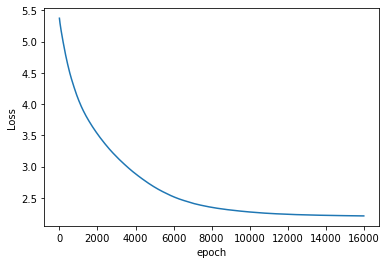

In [460]:
plt.plot(loss_collection[:])
plt.ylabel("Loss")
plt.xlabel("epoch")

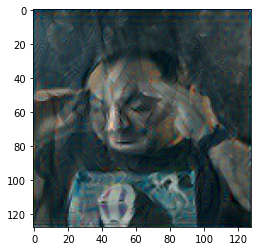

In [464]:
# final output
plt.imshow(tf.reshape(target_img, [im_size,im_size,3]))
plt.savefig("me_picasso.png")